In [429]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import os
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
print('Is GPU available:', torch.cuda.is_available())

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [432]:
# デバイスとハイパーパラメータ

# デバイスの準備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

# バッチサイズの指定
batchsize = 128

# 回すエポック数の指定
n_epochs = 100

# 学習率の指定
learning_rate = 0.001

# 乱数シードの指定
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
# VAEの潜在空間の次元数の指定
embed_dim = 20

# 画像を保存するディレクトリ名の指定
output_dir = './VAE_' + str(embed_dim)
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

device: cuda


In [433]:
# データセットの準備

# Tensorにして、-1～1の範囲に正規化
tf = transforms.Compose([transforms.ToTensor()])
#                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 今回はMNISTを使用
mnist_train = datasets.MNIST(root = '../../data', train = True, transform = tf, download = True)
mnist_test = datasets.MNIST(root = '../../data', train = False, transform = tf, download = False)

# データローダーを容易
mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True, num_workers = 4)
mnist_test_loader = DataLoader(mnist_test, batch_size = batchsize, shuffle = True, num_workers = 4)

print('The number of training data:', len(mnist_train))
print('The number of test data:', len(mnist_test))

The number of training data: 60000
The number of test data: 10000


In [434]:
# VAEのencoderを定義
class Encoder(nn.Module):
    def __init__(self, n_out):
        super(Encoder, self).__init__()
        self.cv1 = nn.Conv2d(1,  32, kernel_size = 5, stride = 2, padding = 2)
        self.cv2 = nn.Conv2d(32, 64, kernel_size = 4, stride = 2, padding = 1)
        self.fc3 = nn.Linear(64*7*7, 256)
        self.fc4_mean = nn.Linear(256, n_out)
        self.fc4_logvar = nn.Linear(256, n_out)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        h = self.cv1(x)
        h = self.bn1(h)
        h = F.leaky_relu(h)
        
        h = self.cv2(h)
        h = self.bn2(h)
        h = F.leaky_relu(h)
        
        h = h.view(h.size(0), -1)
        
        h = self.fc3(h)
        h = self.bn3(h)
        h = F.leaky_relu(h)
        
        out_mean = self.fc4_mean(h)
        out_logvar = self.fc4_logvar(h)
        return out_mean, out_logvar

In [435]:
# VAEのdecoderを定義
class Decoder(nn.Module):
    def __init__(self, n_in):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(n_in, 256)
        self.fc2 = nn.Linear(256, 64*7*7)
        self.tc3 = nn.ConvTranspose2d(64, 32, kernel_size = 4, stride = 2, padding = 1)
        self.tc4 = nn.ConvTranspose2d(32, 1, kernel_size =  4, stride = 2, padding = 1)
        
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(64*7*7)
        self.bn3 = nn.BatchNorm2d(32)
        
    def forward(self, x):
        h = self.fc1(x)
        h = self.bn1(h)
        h = F.leaky_relu(h)

        h = self.fc2(h)
        h = self.bn2(h)
        h = F.leaky_relu(h)
        
        h = h.view(h.size(0), 64, 7, 7)
        
        h = self.tc3(h)
        h = self.bn3(h)
        h = F.leaky_relu(h)
        
        out = self.tc4(h)
        out = torch.sigmoid(out)
        return out

In [436]:
# encoderとdecoderをまとめ、reparametrization trick等を合わせてまとめてVAEを構成
class VAE(nn.Module):
    def __init__(self, n_emb):
        super(VAE, self).__init__()
        self.n_emb = n_emb
        self.encoder = Encoder(n_emb)
        self.decoder = Decoder(n_emb)
        
    def embed(self, x):
        out_mean, out_logvar = self.encoder(x)
        return out_mean, out_logvar
    
    def sample(self, n_sample):
        z = torch.randn(n_sample, self.n_emb).to(device)
        out = self.decoder(z)
        return out
    
    def forward(self, x):
        out_mean, out_logvar = self.embed(x)
        eps = torch.randn(out_mean.size()).to(device)
        z = (0.5 * out_logvar).exp() * eps + out_mean
        out = self.decoder(z)
        return out, out_mean, out_logvar

In [437]:
# ネットワークを実体化、オプティマイザを定義
net = VAE(embed_dim)
net = net.to(device) # CPU/GPUにモデルを送信

# オプティマイザは取り敢えずAdam, 学習率は上で指定、weight_decayを適当にかける
optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay = 0.0005)

# モデルのtarinableな(勾配を要求する)パラメータの数をカウントする（.numel()で要素数の合計がわかる）
num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 1699209

Model:
 VAE(
  (encoder): Encoder(
    (cv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (cv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc3): Linear(in_features=3136, out_features=256, bias=True)
    (fc4_mean): Linear(in_features=256, out_features=20, bias=True)
    (fc4_logvar): Linear(in_features=256, out_features=20, bias=True)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=3136, bias=True)
    (tc3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (tc4): ConvTranspose2d(32, 1, kernel_size=(4, 

In [438]:
# VAEのロス関数を定義
def loss_VAE(recon_x, x, out_mean, out_logvar):
    recon_err = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kldiv_err = -0.5 * torch.sum(1 + out_logvar - out_mean.pow(2) - out_logvar.exp())
    final_err = recon_err + kldiv_err
    
    return final_err, recon_err, kldiv_err

In [439]:
# １エポック分の学習を行う関数
def train(train_loader):
    net.train() # モデルを学習モードにする
    running_final_loss = 0
    running_recon_loss = 0
    running_kldiv_loss = 0
    
    for inputs, _ in train_loader:
        inputs =  inputs.to(device) # モデルとTensorを同じインタフェースでCPU/GPU転送できる 
        recon_inputs, out_mean, out_logvar = net(inputs)
        final_loss, recon_loss, kldiv_loss = loss_VAE(recon_inputs, inputs, out_mean, out_logvar)
        
        optimizer.zero_grad()
        final_loss.backward()
        optimizer.step()
        
        running_final_loss += final_loss.item() # .item()でスカラ値を単要素Tensorから取り出す
        running_recon_loss += recon_loss.item()
        running_kldiv_loss += kldiv_loss.item()
        
    final_loss = running_final_loss / len(train_loader.dataset)
    recon_loss = running_recon_loss / len(train_loader.dataset)
    kldiv_loss = running_kldiv_loss / len(train_loader.dataset)

    return final_loss, recon_loss, kldiv_loss # 戻り値は訓練誤差

In [440]:
# 1ポック分のテスト（実質バリデーションだが）を行う関数
def test(test_loader, epoch):
    net.eval() # モデルを学習モードにする
    running_final_loss = 0
    running_recon_loss = 0
    running_kldiv_loss = 0
    
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs =  inputs.to(device) # モデルとTensorを同じインタフェースでCPU/GPU転送できる 
            recon_inputs, out_mean, out_logvar = net(inputs)
            final_loss, recon_loss, kldiv_loss = loss_VAE(recon_inputs, inputs, out_mean, out_logvar)
        
            running_final_loss += final_loss.item() # .item()でスカラ値を単要素Tensorから取り出す
            running_recon_loss += recon_loss.item()
            running_kldiv_loss += kldiv_loss.item()
        
    final_loss = running_final_loss / len(test_loader.dataset)
    recon_loss = running_recon_loss / len(test_loader.dataset)
    kldiv_loss = running_kldiv_loss / len(test_loader.dataset)
    
    # 10エポックごとに最後のミニバッチの生成画像を保存する
    if epoch % 5 == 0:
        n_save_image = 8        
        comparison = torch.cat([inputs[:n_save_image], recon_inputs[:n_save_image]])
        save_image(comparison.data.cpu(),'{}/reconstruction_{}.png'.format(output_dir, epoch), nrow=n_save_image)
        
    return final_loss, recon_loss, kldiv_loss # 戻り値はテスト（バリデーション）誤差

In [441]:
# 学習の実行と、モデルの保存（学習ログは.npyで、モデル状態は.pthで　←　モデル状態の保存は他にもいろいろある？）
train_loss_list = [[],[],[]]
test_loss_list = [[],[],[]]
for epoch in range(n_epochs):
    train_final_loss, train_recon_loss, train_kldiv_loss = train(mnist_train_loader)
    test_final_loss, test_recon_loss, test_kldiv_loss  = test(mnist_test_loader, epoch)
    
    train_loss_list[0].append(train_final_loss)
    train_loss_list[1].append(train_recon_loss)
    train_loss_list[2].append(train_kldiv_loss)

    test_loss_list[0].append(test_final_loss)
    test_loss_list[1].append(test_recon_loss)
    test_loss_list[2].append(test_kldiv_loss)

    print('epoch[%d/%d] train_loss:%1.4f test_loss:%1.4f' % \
                                (epoch+1, n_epochs, train_final_loss, test_final_loss))


np.save(output_dir + '/train_loss_list.npy', np.array(train_loss_list))
np.save(output_dir + '/validation_loss_list.npy', np.array(test_loss_list))

torch.save(net.state_dict(), output_dir + '/VAE.pth')

epoch[1/100] train_loss:177.2664 test_loss:119.4522
epoch[2/100] train_loss:111.4188 test_loss:104.2230
epoch[3/100] train_loss:105.7080 test_loss:101.8515
epoch[4/100] train_loss:103.6217 test_loss:100.4456
epoch[5/100] train_loss:102.5155 test_loss:99.6257
epoch[6/100] train_loss:101.7042 test_loss:98.9038
epoch[7/100] train_loss:101.0049 test_loss:98.3381
epoch[8/100] train_loss:100.5779 test_loss:98.0717
epoch[9/100] train_loss:100.1059 test_loss:97.6277
epoch[10/100] train_loss:99.7561 test_loss:97.4248
epoch[11/100] train_loss:99.4179 test_loss:97.4128
epoch[12/100] train_loss:99.1303 test_loss:96.9979
epoch[13/100] train_loss:98.9199 test_loss:96.7991
epoch[14/100] train_loss:98.6686 test_loss:96.5615
epoch[15/100] train_loss:98.4650 test_loss:96.5994
epoch[16/100] train_loss:98.3285 test_loss:96.3473
epoch[17/100] train_loss:98.0212 test_loss:96.1340
epoch[18/100] train_loss:97.7793 test_loss:96.1194
epoch[19/100] train_loss:97.7283 test_loss:95.9842
epoch[20/100] train_loss:97

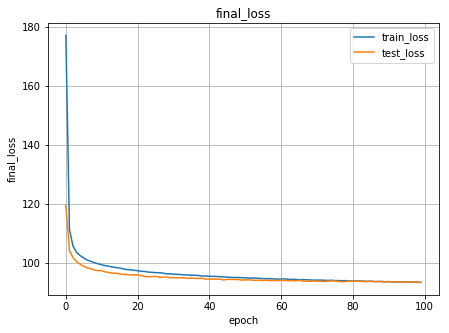

In [442]:
# 学習ログの可視化
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[0], label = 'train_loss')
plt.plot(test_loss_list[0], label = 'test_loss')
plt.title('final_loss')
plt.xlabel('epoch')
plt.ylabel('final_loss')
plt.legend()
plt.grid()
plt.show()

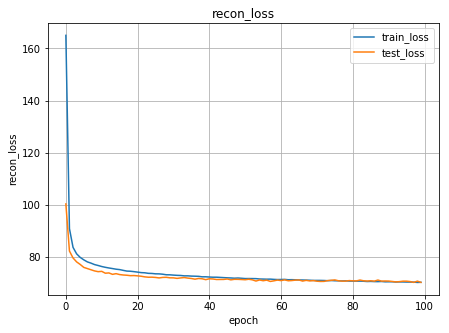

In [443]:
# 学習ログの可視化
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[1], label = 'train_loss')
plt.plot(test_loss_list[1], label = 'test_loss')
plt.title('recon_loss')
plt.xlabel('epoch')
plt.ylabel('recon_loss')
plt.legend()
plt.grid()
plt.show()

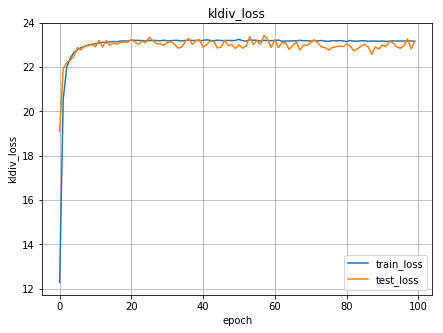

In [444]:
# 学習ログの可視化
plt.figure(figsize = (7,5))
plt.plot(train_loss_list[2], label = 'train_loss')
plt.plot(test_loss_list[2], label = 'test_loss')
plt.title('kldiv_loss')
plt.xlabel('epoch')
plt.ylabel('kldiv_loss')
plt.legend()
plt.grid()
plt.show()

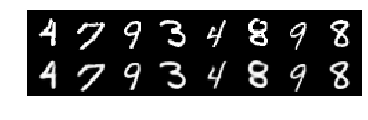

In [445]:
# 再構成した画像を見てみる 上が元画像で、下が再構成画像
show_epoch = 90
comparison_img = Image.open(output_dir + '/reconstruction_' + str(show_epoch) + '.png')
plt.axis('off')
plt.imshow(comparison_img)

torch.Size([5, 1, 28, 28])
torch.Size([3, 30, 146])


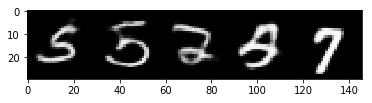

In [451]:
# 画像をサンプルしてみてみる
net.eval()
with torch.no_grad():
    sampled_images = net.sample(5)
print(sampled_images.size())
sampled_images = make_grid(sampled_images, padding = 1)
print(sampled_images.size())
sampled_images = sampled_images.cpu().numpy()
sampled_images = np.transpose(sampled_images, (1, 2, 0))
plt.imshow(sampled_images)

In [425]:
loader_for_show = DataLoader(mnist_test, batch_size = 10000, shuffle = False, num_workers = 4) 
images, labels = iter(loader_for_show).next()
images = images.to(device)

net.eval()
with torch.no_grad():
    out_mean, out_logvar = net.embed(images)
print(out_mean.size())

torch.Size([10000, 2])


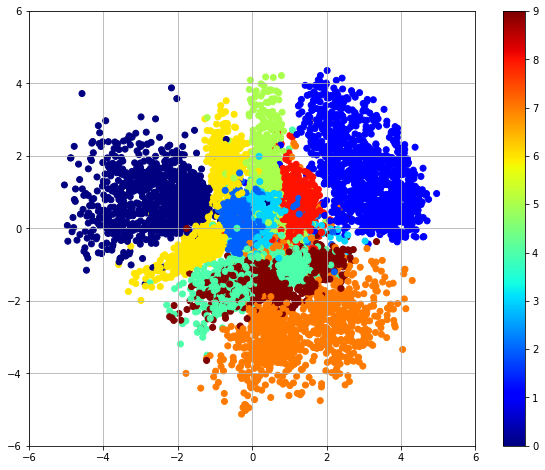

In [426]:
plt.figure(figsize = (10,8))
plt.scatter(out_mean[:,0], out_mean[:,1], c = labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.grid()
plt.show()